In [3]:
import sys
import os
script_dir = os.path.dirname(os.path.realpath('__file__'))
parent_dir = os.path.dirname(script_dir)
sys.path.insert(0, parent_dir)

import functions
import models
import gradcam
import pickle
from sklearn.model_selection import train_test_split
import torch
from torchvision import transforms
from torch.utils.data import Subset, DataLoader
from torch.utils.tensorboard import SummaryWriter

In [5]:
# Use the GPU instead of the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Define the label maps
dataset_path = '/mnt/ssd/dataset/scardovi/genimage256'
dataset_path = '/home/scardovi/genimage256'

with open(os.path.join(dataset_path, 'imagenet_classes.txt'), 'r') as file:
    labels = [line.strip() for line in file.readlines()]
multiclass_labels_map = {index: label for index, label in enumerate(labels)}

# Compose the transform that will be applied to the data
transform = transforms.Compose([
    transforms.ToTensor(),
])

# training
train_ds = functions.MulticlassGenImage(img_dir=dataset_path, transform=transform)

# validation and testing
val_ground_truth = functions.val_mapping(dataset_path)
val_test_ds= functions.MulticlassGenImage(img_dir=dataset_path, val_gt=val_ground_truth, transform=transform)
# Perform a stratified split
stratify_labels = [f"{label['generator']}{label['multiclass']}" for label in val_test_ds.img_labels]
idx_val, idx_test = train_test_split(
    range(len(val_test_ds)),
    test_size=0.5,  # 50-50 split
    random_state=0
)
validation_ds = Subset(val_test_ds, idx_val)
test_ds = Subset(val_test_ds, idx_test)

cuda




 - multiclass_finetuning_batch64
- Epoch 1: current lr = 1e-04
Train error: Combined=48.54%; Multiclass=38.33%; Generator=14.66%; 
Validation error: Combined=41.86%;  Multiclass=33.14%; Generator=12.58%; 
Train loss: 4.823e+00; Val loss: 1.912e+00
- Epoch 2: current lr = 1e-04
Train error: Combined=42.17%; Multiclass=33.91%; Generator=10.92%; 
Validation error: Combined=35.70%;  Multiclass=28.77%; Generator=9.30%; 
Train loss: 2.312e+00; Val loss: 1.505e+00
- Epoch 3: current lr = 1e-04
Train error: Combined=39.65%; Multiclass=32.18%; Generator=9.47%; 
Validation error: Combined=34.24%;  Multiclass=27.18%; Generator=8.95%; 
Train loss: 1.965e+00; Val loss: 1.376e+00
- Epoch 4: current lr = 1e-04
Train error: Combined=38.03%; Multiclass=31.02%; Generator=8.69%; 
Validation error: Combined=32.32%;  Multiclass=26.34%; Generator=7.51%; 
Train loss: 1.778e+00; Val loss: 1.306e+00
- Epoch 5: current lr = 1e-04
Train error: Combined=36.83%; Multiclass=30.20%; Generator=8.05%; 
Validation er

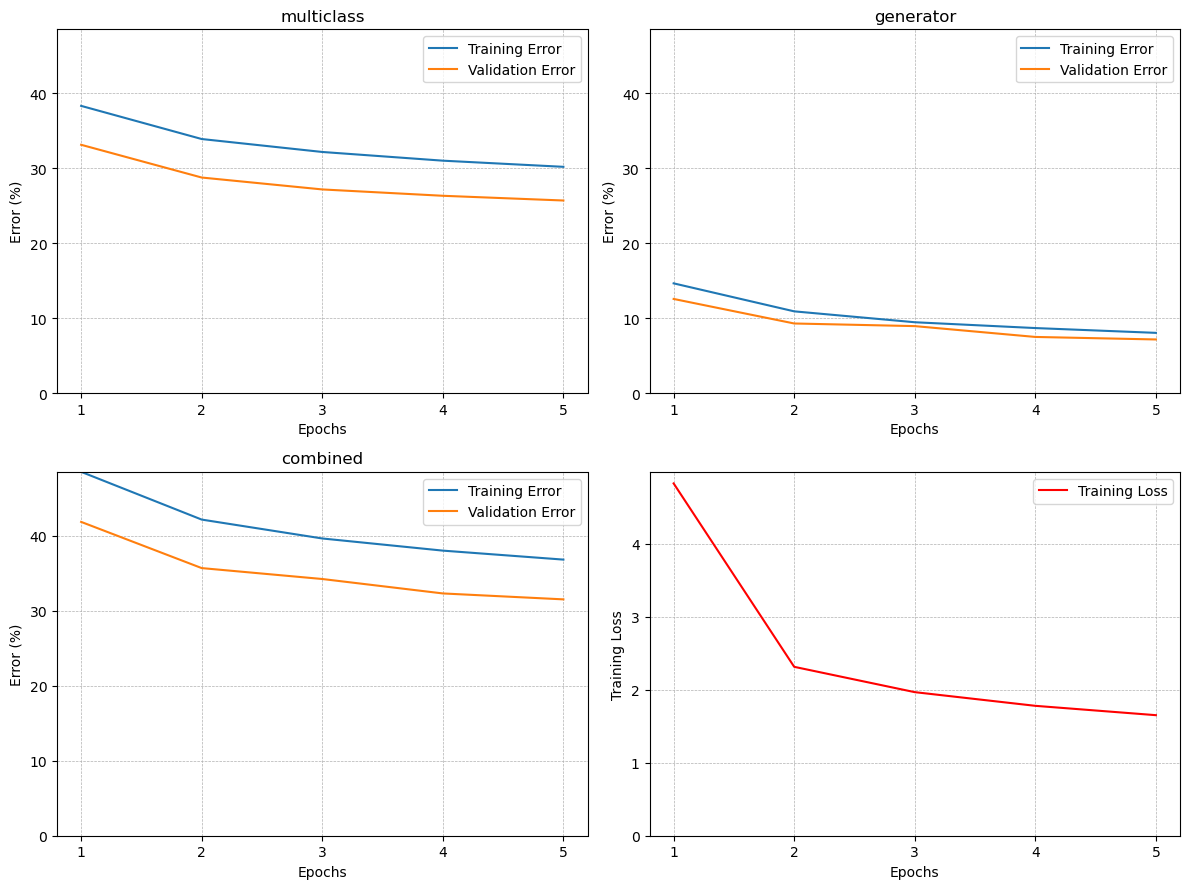

In [7]:
model_init_function = models.multiclass_finetuning
epochs = 5
batch_size = 64
lr = 0.0001
val_batch_size = 64


val_dl = DataLoader(validation_ds, batch_size=val_batch_size, num_workers=6, prefetch_factor=6, pin_memory=True)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=6, pin_memory=True, prefetch_factor=6)

# Initialize the model
model = model_init_function()
model = model.to(device)
model_name = f"{model_init_function.__name__}_batch{batch_size}"
print("\n\n - " + model_name)

# Train the model
train_errors, val_errors, train_loss = functions.train_network_multioutput(model, device, lr, epochs, train_dl, val_dl)
functions.plot_training_stats_multioutput(train_errors, val_errors, train_loss)
model_name += f"_epochs{len(train_errors['generator'])}"

# Save the progress
torch.save(model.state_dict(), './weights/' + model_name + '_short.pth')
stats_dict = {
'train_errors': train_errors,
'val_errors': val_errors,
'train_loss': train_loss
}
with open('./stats/' + model_name + '_short.pkl', 'wb') as f:
    pickle.dump(stats_dict, f)

# Model training

In [ ]:
model_init_function = models.multiclass_finetuning
epochs = 90
batch_size = 64
lr = 0.1
val_batch_size = 64
scheduler_patience=7

val_dl = DataLoader(validation_ds, batch_size=val_batch_size, num_workers=6, prefetch_factor=6, pin_memory=True)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=6, pin_memory=True, prefetch_factor=6)

# Initialize the model
model = model_init_function()
model = model.to(device)
model_name = f"{model_init_function.__name__}_batch{batch_size}"
print("\n\n - " + model_name)
writer = SummaryWriter('logs/'+model_name)

# Train the model
train_errors, val_errors, train_loss = functions.train_network_multioutput(model, device, lr, epochs, train_dl, val_dl, writer=writer, scheduler_patience=scheduler_patience)
functions.plot_training_stats_multioutput(train_errors, val_errors, train_loss)
model_name += f"_epochs{len(train_errors['generator'])}"
writer.close()

# Save the progress
torch.save(model.state_dict(), './weights/' + model_name + '.pth')
stats_dict = {
'train_errors': train_errors,
'val_errors': val_errors,
'train_loss': train_loss
}
with open('./stats/' + model_name + '.pkl', 'wb') as f:
    pickle.dump(stats_dict, f)